In [265]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import os
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

% matplotlib inline
warnings.filterwarnings('ignore')

In [266]:
data_transforms = {
    'flip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'notflip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [267]:
df_relation=pd.read_csv('./twins-relationship-info.csv')
df_relation.sample(3)
#df_relation.shape

,Unnamed: 0,subject_id1,subject_id2,relationship_type
223,224,nd1S90267,nd1S90266,Identical
167,168,nd1S90196,nd1S90195,Identical
238,239,nd1S90278,nd1S90279,Identical


In [268]:
df=pd.read_csv('./image-metadata-2.0.csv')
df.sample(3)
#df.shape

,filename,date,gender,race,yearofbirth,weather,glasses,expression,yaw,Unnamed: 9
960,90011d62.nef,2009-08-08 00:00:00,Female,White,1987,Rain,prism,BlankStare,0,90011d62.nef
4922,90055d20.nef,2009-08-08 00:00:00,Female,White,1965,Inside,prism,BlankStare,0,90055d20.nef
16419,90242d33.nef,2009-08-09 00:00:00,Female,White,1945,Inside,prism,Happiness,-90,90242d33.nef


In [287]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df_img,df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe with fields 
        transform: torchvision flip and notflip transforms for  images(dict)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
        
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        #monetochka=np.random.randint(0,2)
        monetochka=0
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
            relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values
            
            if relation in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                flag='Twins'
                find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                id_b=self.df['filename'].loc[find_id[find_id!=-1].index[0]]
                img_b = Image.open(get_img_path(id_b))
                img_b=self.transform['notflip'](img_b)
            else:
                id_b=id_a.copy()
                img_b=img_a.copy()
                img_b=self.transform['flip'](img_b)
                flag='Not Twins'
        else:
            id_b=id_a.copy()
            img_b=img_a.copy()
            img_b=self.transform['flip'](img_b)
            flag='Not Twins'
    
        img_a = self.transform['notflip'](img_a)
        #img_b = self.transform(img_b)
        #print(id_a)
        #print(id_b)
        id_a=id_a[:5]
        id_b=id_b[:5]
        return {'img_a': img_a, 'img_b': img_b, 'class_a':id_a,'class_b':id_b,'label':flag}

    def __len__(self):
        return self.df.shape[0]

In [290]:
direct='./nd-twins-0006/faces/'
twins_dataset = TwinsDataloader(direct, df,df_relation ,data_transforms)

dataset = DataLoader(twins_dataset, batch_size=5,shuffle=True)

['90101', '90285', '90256', '90120', '90014']
['90100', '90284', '90257', '90121', '90015']


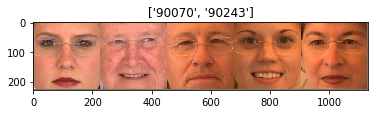

In [291]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))

inputs=T['img_a']
print(T['class_a'])
print(T['class_b'])
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])